In [96]:
import cv2
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18, resnet50

In [97]:
def image_arrs(paths, im_arr):
    for path in paths:
        #read images, may need to change filepath
        fp = os.path.join('GTSRB Data', 'train.csv')
        image = cv2.imread('GTSRB Data/'+path)
        image_from_array = Image.fromarray(image, 'RGB')
        #resize all images to 30x30
        size_image = image_from_array.resize((30, 30))
        #convert images to array
        image_arr = np.array(size_image.getdata(),
                        np.uint8).reshape(size_image.size[1], size_image.size[0], 3)
        im_arr.append(image_arr.flatten())
    return im_arr

In [98]:
#this may take a minute
fp = os.path.join('GTSRB Data', 'train.csv')
df = pd.read_csv(fp)
#all filepaths for class 1 and 2
paths1 = df[(df['ClassId']==1)]['Path'].values
paths2 = df[(df['ClassId']==2)]['Path'].values
paths3 = df[(df['ClassId']==3)]['Path'].values

class1_arrs = []
class1_arrs = image_arrs(paths1, class1_arrs)

class2_arrs = []
class2_arrs = image_arrs(paths2, class2_arrs)

class3_arrs = []
class3_arrs = image_arrs(paths3, class3_arrs)

True

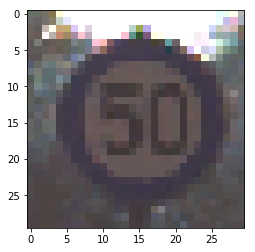

In [99]:
#class 1 images
plt.imshow(class1_arrs[0].reshape(30, 30, 3))

#class 2 images
plt.imshow(class2_arrs[50].reshape(30, 30, 3))


#concat data and labels 
X = class1_arrs + class2_arrs + class3_arrs
y = len(class1_arrs)*[0] + len(class2_arrs)*[1] + len(class3_arrs)*[2]

#check data is the same length as labels
len(X)==len(y)

In [100]:
torched_X = torch.from_numpy(np.array(X)).float()
torched_y = torch.from_numpy(np.array(y)).long()

In [101]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = torch.from_numpy(np.array(X_train)).float()
y_train = torch.from_numpy(np.array(y_train)).long()
X_test = torch.from_numpy(np.array(X_test)).float()
y_test = torch.from_numpy(np.array(y_test)).long()

start_model = LogisticModel()

In [102]:
class LogisticModel(torch.nn.Module):
    def __init__(self):
        super(LogisticModel, self).__init__()
        self.linear = torch.nn.Linear(2700, 1)
        
    def forward(self, x_val):
        y_pred = torch.sigmoid(self.linear(x_val))
        return y_pred

In [103]:
model = LogisticModel()

In [119]:
class newNeural(torch.nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, num_classes):
        
        super(newNeural, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden1_size)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(hidden3_size, hidden4_size)
        self.relu4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(hidden4_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out
        

In [116]:
def train_model(model, inp, outp):
    
    losses = []
    
    criterion = torch.nn.CrossEntropyLoss()
    #first param take param of model (x_data) learning rate is 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for instance in range(1000):
        y_pred = model(inp)

        loss = criterion(y_pred, outp)
        losses.append(loss.data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

In [92]:
def get_preds(model, x_val):
    check_x = []
    predictions = model(x_val)
    
    for i in predictions:
        check_x.append(np.argmax(list(i)))
        
    return check_x

In [109]:
new_model = newNeural(2700, 100, 50, 3)

In [111]:
first_try = new_model(X_train)

# Attempt 1

In [112]:
trained_nn = train_model(new_model, X_train, y_train)

tensor(0.0753)


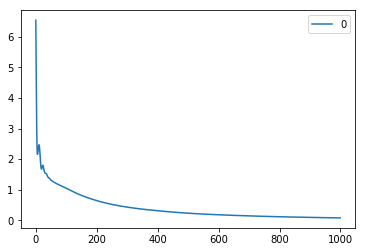

In [113]:
print(trained_nn[-1])
pd.DataFrame(trained_nn).plot(kind='line')

In [132]:
x_preds_1 = get_preds(new_model, X_train)
x_real_1 = get_preds(new_model, X_test)

In [133]:
print(accuracy_score(x_preds_1, y_train), accuracy_score(x_real_1, y_test))

0.9891581632653061 0.9404761904761905


# Attempt 2

In [117]:
new_model_2 = newNeural(2700, 150, 90, 50, 3)
trained_nn_2 = train_model(new_model_2, X_train, y_train)

tensor(0.0339)


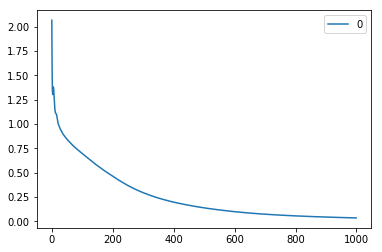

In [118]:
print(trained_nn_2[-1])
pd.DataFrame(trained_nn_2).plot(kind='line')

In [127]:
x_preds_2 = get_preds(new_model_2, X_train)
x_real_2 = get_preds(new_model_2, X_test)

In [128]:
print(accuracy_score(x_preds_2, y_train), accuracy_score(x_real_2, y_test))

0.9997874149659864 0.9583333333333334


# Attempt 3

In [120]:
#learning rate = 0.00001
new_model_3 = newNeural(2700, 200, 160, 100, 40, 3)
trained_nn_3 = train_model(new_model_3, X_train, y_train)

tensor(0.0126)


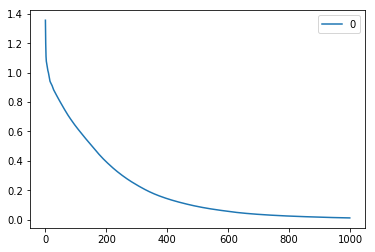

In [121]:
print(trained_nn_3[-1])
pd.DataFrame(trained_nn_3).plot(kind='line')

In [129]:
x_preds_3 = get_preds(new_model_3, X_train)
x_real_3 = get_preds(new_model_3, X_test)

In [130]:
print(accuracy_score(x_preds_3, y_train), accuracy_score(x_real_3, y_test))

1.0 0.9591836734693877
